In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

In [2]:
import warnings
warnings.filterwarnings('ignore') ## hide warnings
warnings.simplefilter(action = 'ignore', category= RuntimeWarning)

In [3]:
import datetime as dt # 시계열을 다루기 때문에 필요

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import io
import statistics as st

In [5]:
df = pd.read_csv("./sales_data.csv", encoding='latin-1')

In [6]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [7]:
df.shape

(541909, 8)

In [8]:
## 54만개, 8개 features


In [9]:

df.count(axis=0, numeric_only=False)

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [10]:

# 시간을 형식에 맞게 바꿔서 index 로

df.index = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)
df.drop('InvoiceDate', axis=1, inplace=True)

In [11]:
df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France


In [12]:
(df.isnull().sum() / df.shape[0]).sort_values()

InvoiceNo      0.000000
StockCode      0.000000
Quantity       0.000000
UnitPrice      0.000000
Country        0.000000
Description    0.002683
CustomerID     0.249267
dtype: float64

In [13]:
## ID 의 25% 가 없으므로 이 열을 쓰지 않거나, 누락된 행을 제외하는 걸 고민

df2 = df.copy()

In [14]:
df2.dropna(axis=0, inplace = True)

In [15]:
df2.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 406829 entries, 2010-12-01 08:26:00 to 2011-12-09 12:50:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   UnitPrice    406829 non-null  float64
 5   CustomerID   406829 non-null  float64
 6   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [17]:
# quntity 가 0 보다 작은 열음 의미가 없음 (판매데이터이므로)
df2 = df2[df2.Quantity > 0]  

In [18]:
df2

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France


In [19]:
# 단가가 0인 상품의 판매도 의미가 없음 
(df2['UnitPrice'] == 0).sum()

40

In [20]:
df2 = df2[df2.UnitPrice > 0]

In [21]:
df2

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France


In [22]:
## 총 매출을 예측하기 위해서 총 매출액을 만듬

df2['TotalAmount'] = df2['Quantity'] * df2['UnitPrice'] 

In [23]:
df2

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalAmount
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60


In [24]:
## pd.datetime 으로부터 여러 시계열 정보를 쉽게 뽑을 수 있음. -> 나중에 휴일 정보등을 위해서 필요함
## date, day, year, month, day of year 등등등... 

df2['Year'] = df2.index.year
df2['Quarter'] = df2.index.quarter
df2['Month'] = df2.index.month
df2['Weekday'] = df2.index.weekday
df2['day'] = df2.index.day
df2['Date'] = df2.index.date

In [25]:
df2

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,TotalAmount,Year,Quarter,Month,Weekday,day,Date
InvoiceDate,,,,,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,15.30,2010,4,12,2,1,2010-12-01
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,2,1,2010-12-01
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,22.00,2010,4,12,2,1,2010-12-01
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,2,1,2010-12-01
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,20.34,2010,4,12,2,1,2010-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-09 12:50:00,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680.0,France,10.20,2011,4,12,4,9,2011-12-09
2011-12-09 12:50:00,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680.0,France,12.60,2011,4,12,4,9,2011-12-09
2011-12-09 12:50:00,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680.0,France,16.60,2011,4,12,4,9,2011-12-09


In [26]:
group_ = ["Date", "Year", "Quarter", "Month", "StockCode"]

In [27]:
df3 = pd.DataFrame( df2.groupby(group_).Quantity.sum(), columns=["Quantity"]) 

In [28]:
df3

Quantity
Date       Year Quarter Month StockCode          
2010-12-01 2010 4       12    10002            60
                              10125             2
                              10133             5
                              15044B            1
                              15056BL          20
...                                           ...
2011-12-09 2011 4       12    85099C           10
                              85123A            1
                              85152            48
                              85173            12
                              POST              9

[222370 rows x 1 columns]

In [29]:
df3["TotalAmount"] = df2.groupby(group_).TotalAmount.sum()

In [30]:
df3

Quantity  TotalAmount
Date       Year Quarter Month StockCode                       
2010-12-01 2010 4       12    10002            60        51.00
                              10125             2         1.70
                              10133             5         4.25
                              15044B            1         2.95
                              15056BL          20       113.00
...                                           ...          ...
2011-12-09 2011 4       12    85099C           10        17.90
                              85123A            1         2.95
                              85152            48        88.80
                              85173            12         9.48
                              POST              9       159.00

[222370 rows x 2 columns]

In [31]:
df3 = df3.reset_index()

In [32]:
df3

,Date,Year,Quarter,Month,StockCode,Quantity,TotalAmount
0,2010-12-01,2010,4,12,10002,60,51.00
1,2010-12-01,2010,4,12,10125,2,1.70
2,2010-12-01,2010,4,12,10133,5,4.25
3,2010-12-01,2010,4,12,15044B,1,2.95
4,2010-12-01,2010,4,12,15056BL,20,113.00
...,...,...,...,...,...,...,...
222365,2011-12-09,2011,4,12,85099C,10,17.90
222366,2011-12-09,2011,4,12,85123A,1,2.95
222367,2011-12-09,2011,4,12,85152,48,88.80
222368,2011-12-09,2011,4,12,85173,12,9.48


In [33]:
df3.loc[:, ["Quantity", "TotalAmount"]].describe()

,Quantity,TotalAmount
count,222370.00000,222370.000000
mean,23.23970,40.074686
std,241.60083,418.479825
min,1.00000,0.001000
25%,3.00000,6.800000
50%,9.00000,15.800000
75%,24.00000,34.000000
max,80995.00000,168469.600000


In [34]:
## 과도하게 높은 outlier 가 존재하는 거 같음
## 물론 이런 스파이크가 실제 초호황 데이터 일 수 있으나 - 시계열 예측시 이런 호황을 다시 예측하는 것은 어려움  -> 제거가 타당

lower_amount = df3.TotalAmount.quantile(0.01)
upper_amount = df3.TotalAmount.quantile(0.99)

lower_quantity = df3.Quantity.quantile(0.01)
upper_quantity = df3.Quantity.quantile(0.99)


In [35]:
df3.shape

(222370, 7)

In [36]:
df3 = df3.loc[ (df3.Quantity >= lower_quantity) & (df3.Quantity <= upper_quantity)] 
df3 = df3.loc[ (df3.TotalAmount >= lower_amount) & (df3.TotalAmount <= upper_amount)]

In [37]:
df3.shape

(216819, 7)

In [38]:
df4 = df3.groupby('Date', as_index=False)['TotalAmount'].sum()

In [39]:
df4

,Date,TotalAmount
0,2010-12-01,31546.98
1,2010-12-02,32935.45
2,2010-12-03,19411.87
3,2010-12-05,28582.51
4,2010-12-06,23563.71
...,...,...
300,2011-12-05,44402.10
301,2011-12-06,32237.72
302,2011-12-07,39674.98
303,2011-12-08,32059.50


In [40]:
## Prophet 에 맞는 형태로 DF 가공하기

df_prophet = df4[["Date", "TotalAmount"]]
df_prophet = df_prophet.rename(columns = { "Date" : "ds", "TotalAmount":"y"})

In [42]:
df_prophet

,ds,y
0,2010-12-01,31546.98
1,2010-12-02,32935.45
2,2010-12-03,19411.87
3,2010-12-05,28582.51
4,2010-12-06,23563.71
...,...,...
300,2011-12-05,44402.10
301,2011-12-06,32237.72
302,2011-12-07,39674.98
303,2011-12-08,32059.50


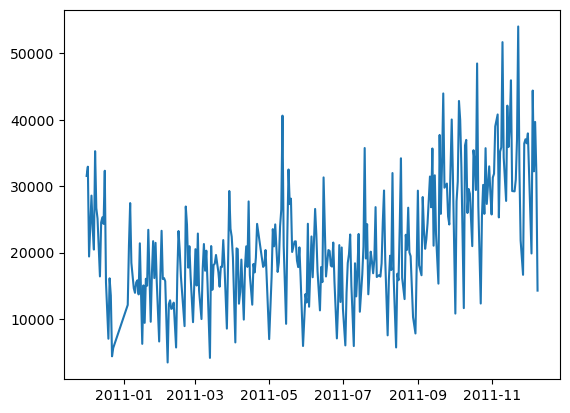

In [43]:
plt.plot( df_prophet.ds, df_prophet.y)

In [44]:
#train test split
## 시계열이므로 무작위로 나눠서는 안됨 
train = df_prophet[:275]
test = df_prophet[275:]

In [45]:
## prophet = Prophet() 
## 이렇게 해도 되지만, (사실 대부분 자동으로 잡아주긴 함) 좀더 디테일한 설명을 위해 

prophet = Prophet( daily_seasonality= False, # 이런 파라메터는 나중에 조절해보장
                  growth = 'linear', #
                  n_changepoints = 25, 
                  changepoint_range= 0.8,
                  yearly_seasonality= 'auto',
                  weekly_seasonality= 'auto',
                  holidays=None,
                  seasonality_mode= 'additive',
                  seasonality_prior_scale=10,
                  holidays_prior_scale=10,
                  changepoint_prior_scale=0.05)

AttributeError: 'Prophet' object has no attribute 'stan_backend'

In [71]:
prophet.fit(train) ## fitting 시작

12:48:11 - cmdstanpy - INFO - Chain [1] start processing
12:48:11 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
future = prophet.make_future_dataframe(periods=30)
future ## 날짜만 있는 빈 데이터 프레임

,ds
0,2010-12-01
1,2010-12-02
2,2010-12-03
3,2010-12-05
4,2010-12-06
...,...
300,2011-11-30
301,2011-12-01
302,2011-12-02
303,2011-12-03


In [73]:
forecast = prophet.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-12-01,18377.492357,11387.037151,25867.305342,18377.492357,18377.492357,255.286136,255.286136,255.286136,255.286136,255.286136,255.286136,0.0,0.0,0.0,18632.778493
1,2010-12-02,18380.323156,15297.304025,29422.381692,18380.323156,18380.323156,4102.059095,4102.059095,4102.059095,4102.059095,4102.059095,4102.059095,0.0,0.0,0.0,22482.382252
2,2010-12-03,18383.153956,9569.918922,24127.937553,18383.153956,18383.153956,-1936.066852,-1936.066852,-1936.066852,-1936.066852,-1936.066852,-1936.066852,0.0,0.0,0.0,16447.087103
3,2010-12-05,18388.815555,2680.755846,17354.417552,18388.815555,18388.815555,-8193.704157,-8193.704157,-8193.704157,-8193.704157,-8193.704157,-8193.704157,0.0,0.0,0.0,10195.111397
4,2010-12-06,18391.646354,10225.369614,25263.575384,18391.646354,18391.646354,-673.055423,-673.055423,-673.055423,-673.055423,-673.055423,-673.055423,0.0,0.0,0.0,17718.590931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2011-11-30,33658.750956,26877.525670,41243.249193,33555.820181,33770.433011,255.286136,255.286136,255.286136,255.286136,255.286136,255.286136,0.0,0.0,0.0,33914.037092
301,2011-12-01,33756.877627,30462.220409,45319.928636,33646.722495,33873.790976,4102.059095,4102.059095,4102.059095,4102.059095,4102.059095,4102.059095,0.0,0.0,0.0,37858.936723
302,2011-12-02,33855.004299,24765.676590,39633.841848,33738.716385,33979.467646,-1936.066852,-1936.066852,-1936.066852,-1936.066852,-1936.066852,-1936.066852,0.0,0.0,0.0,31918.937447
303,2011-12-03,33953.130971,33010.513250,47555.903895,33828.312560,34088.459494,6575.099517,6575.099517,6575.099517,6575.099517,6575.099517,6575.099517,0.0,0.0,0.0,40528.230488


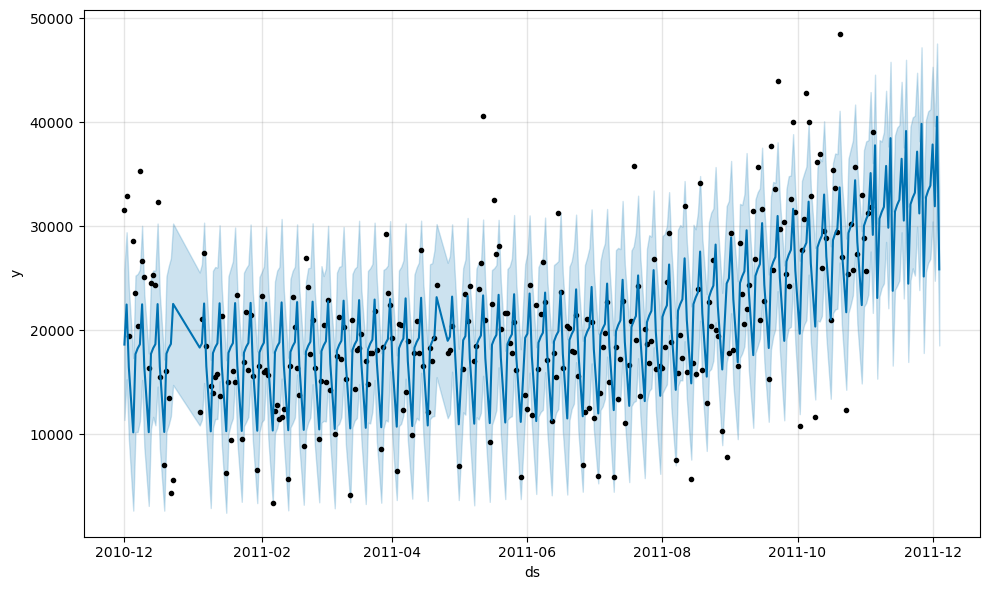

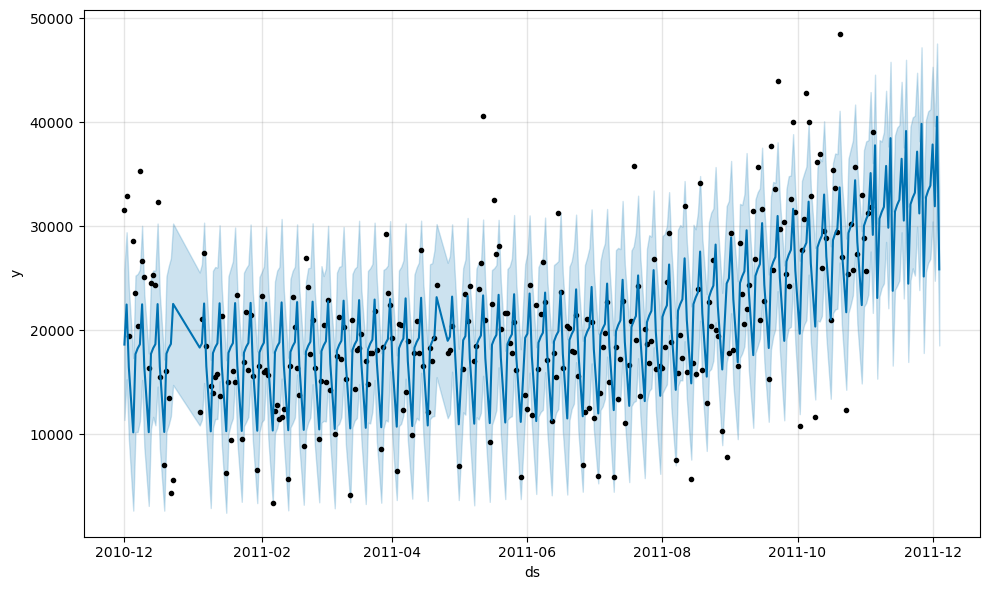

In [74]:
prophet.plot(forecast)

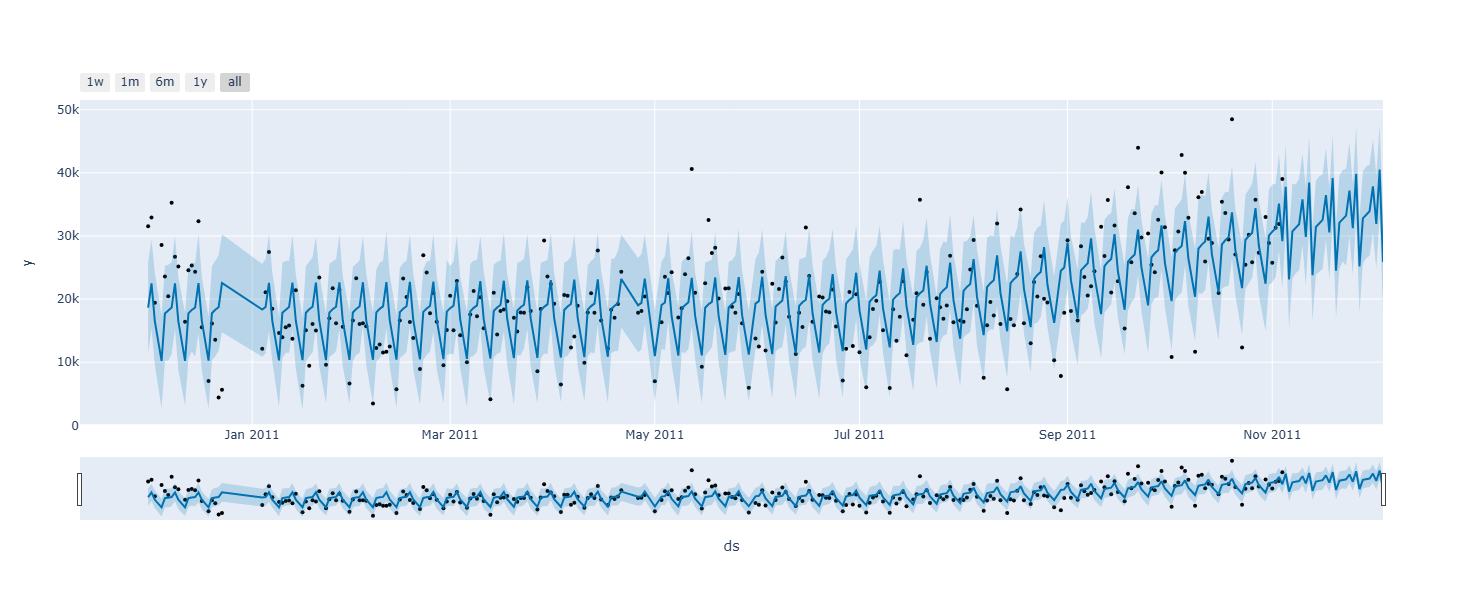

In [75]:
plot_plotly(prophet, forecast) ## intrective 한 그림으로 그리기

In [76]:
y_true = test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values


In [ ]:
## 실제 test와 맞춰보기위해서

In [83]:
y_true = test['y'].values
y_pred = forecast['yhat'][-len(y_true):].values

mae = np.mean(np.abs(y_true -  y_pred))

In [84]:
mae

7548.568275936466

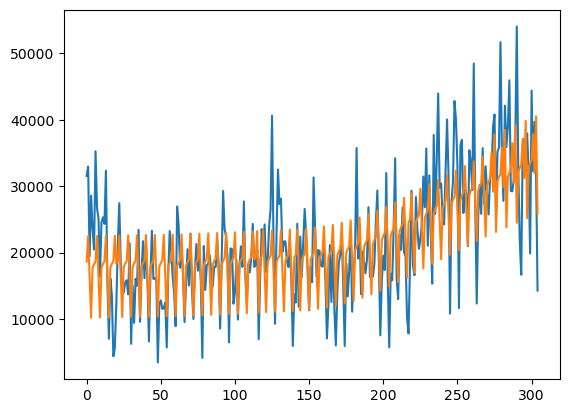

In [89]:
plt.plot( df_prophet.y) 
plt.plot( forecast.yhat)

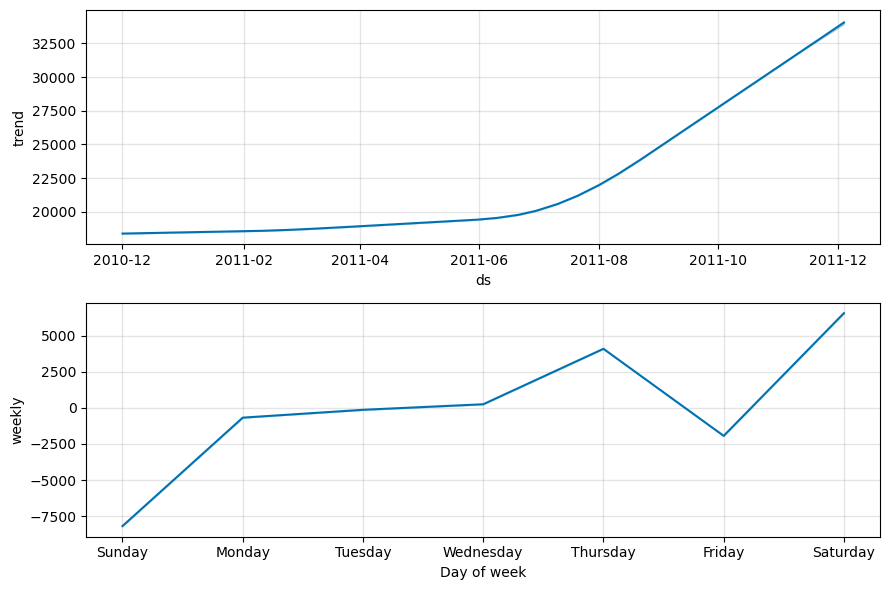

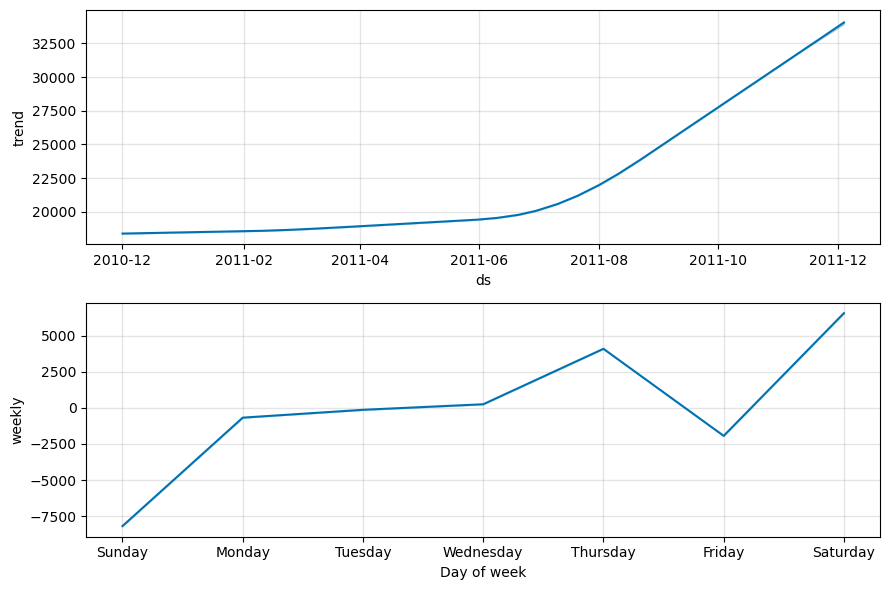

In [91]:
prophet.plot_components(forecast)

In [92]:
## for cross-validation

evalution_model = cross_validation(prophet, initial='200 days', period='50 days', horizon = '25 days')

  0%|          | 0/3 [00:00<?, ?it/s]

12:52:46 - cmdstanpy - INFO - Chain [1] start processing
12:52:46 - cmdstanpy - INFO - Chain [1] done processing
12:52:46 - cmdstanpy - INFO - Chain [1] start processing
12:52:46 - cmdstanpy - INFO - Chain [1] done processing
12:52:47 - cmdstanpy - INFO - Chain [1] start processing
12:52:47 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
evalution_metrix = performance_metrics(evalution_model)

In [94]:
evalution_metrix

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,2.963259e+07,5443.582598,4533.159283,0.323101,0.210293,0.261241,0.833333
1,3 days,1.346598e+07,3669.601855,3018.029705,0.148070,0.099238,0.140874,1.000000
2,4 days,1.197512e+07,3460.508371,3012.453909,0.125272,0.107166,0.126898,1.000000
3,5 days,7.054572e+06,2656.044353,2107.997718,0.091980,0.088131,0.091643,1.000000
4,6 days,5.310591e+06,2304.472022,1862.576715,0.097438,0.088131,0.092666,1.000000
5,7 days,1.360547e+07,3688.559422,2674.308428,0.131200,0.137912,0.129201,0.833333
6,8 days,2.562254e+07,5061.871329,4442.586295,0.328947,0.213170,0.264355,0.833333
7,9 days,4.501980e+07,6709.679266,5230.290990,0.529117,0.194745,0.346062,0.750000
8,10 days,8.013358e+07,8951.736262,6718.818319,0.453367,0.244923,0.322130,0.500000
9,11 days,5.973728e+07,7728.989420,5903.999951,0.237542,0.189696,0.228111,0.666667
